In [1]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

In [3]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

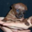

In [4]:
train_ds[0]['img']

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
id2label[train_ds[0]['label']]

'dog'

## Preprocessing the data
We will now preprocess the data. The model requires 2 things: pixel_values and labels.

We will perform data augmentaton on-the-fly using HuggingFace Datasets' set_transform method (docs can be found here). This method is kind of a lazy map: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here.

In [7]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/huggingface_hub-0.23.2-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [9]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [10]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [5, 8],
 'pixel_values': [tensor([[[-0.8510, -0.8510, -0.8510,  ..., -0.8667, -0.8667, -0.8667],
           [-0.8510, -0.8510, -0.8510,  ..., -0.8667, -0.8667, -0.8667],
           [-0.8510, -0.8510, -0.8510,  ..., -0.8667, -0.8667, -0.8667],
           ...,
           [ 0.5137,  0.5137,  0.5137,  ..., -0.2863, -0.2863, -0.2863],
           [ 0.5137,  0.5137,  0.5137,  ..., -0.2863, -0.2863, -0.2863],
           [ 0.5137,  0.5137,  0.5137,  ..., -0.2863, -0.2863, -0.2863]],
  
          [[-0.7098, -0.7098, -0.7098,  ..., -0.7255, -0.7255, -0.7255],
           [-0.7098, -0.7098, -0.7098,  ..., -0.7255, -0.7255, -0.7255],
           [-0.7098, -0.7098, -0.7098,  ..., -0.7255, -0.7255, -0.7255],
           ...,
           [ 0.3333,  0.3333,  0.3333,  ..., -0.3882, -0.3882, -0.3882],
           [ 0.3333,  0.3333,  0.3333,  ..., -0.3882, -0.3882, -0.

In [11]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


### Define the model
Here we define the model. We define a ViTForImageClassification, which places a linear layer (nn.Linear) on top of a pre-trained ViTModel. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image.

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. You can find all info of the model we are going to use here.

We also specify the number of output neurons by setting the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as ```model.config```).

In [13]:

from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/huangjin/opt/anaconda3/envs/ViT/lib/python3.9/site-packages/huggingface_hub-0.23.2-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-2

In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [15]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [16]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [17]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir logs/

Reusing TensorBoard on port 6006 (pid 4570), started 0:03:33 ago. (Use '!kill 4570' to kill it.)

In [18]:
trainer.train()

  0%|          | 0/1350 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.7886078357696533, 'eval_accuracy': 0.954, 'eval_runtime': 12.7643, 'eval_samples_per_second': 39.172, 'eval_steps_per_second': 9.793, 'epoch': 1.0}
{'loss': 1.4503, 'learning_rate': 1.2592592592592593e-05, 'epoch': 1.11}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.48733097314834595, 'eval_accuracy': 0.95, 'eval_runtime': 10.9451, 'eval_samples_per_second': 45.682, 'eval_steps_per_second': 11.421, 'epoch': 2.0}
{'loss': 0.7219, 'learning_rate': 5.185185185185185e-06, 'epoch': 2.22}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.4127110242843628, 'eval_accuracy': 0.966, 'eval_runtime': 11.0781, 'eval_samples_per_second': 45.134, 'eval_steps_per_second': 11.284, 'epoch': 3.0}
{'train_runtime': 1082.3699, 'train_samples_per_second': 12.473, 'train_steps_per_second': 1.247, 'train_loss': 0.9572329711914063, 'epoch': 3.0}


TrainOutput(global_step=1350, training_loss=0.9572329711914063, metrics={'train_runtime': 1082.3699, 'train_samples_per_second': 12.473, 'train_steps_per_second': 1.247, 'train_loss': 0.9572329711914063, 'epoch': 3.0})

### Evaluation
Finally, let's evaluate the model on the test set:

In [20]:
outputs = trainer.predict(test_ds)

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
print(outputs.metrics)

{'test_loss': 0.41210535168647766, 'test_accuracy': 0.9685, 'test_runtime': 59.7513, 'test_samples_per_second': 33.472, 'test_steps_per_second': 8.368}


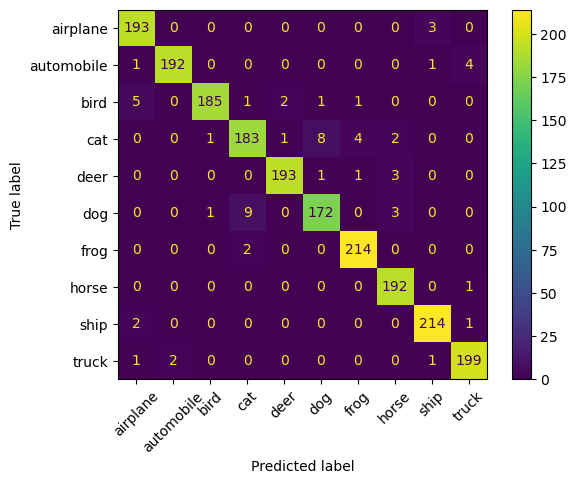

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [28]:
%reload_ext tensorboard

In [23]:
y_true

array([3, 8, 8, ..., 9, 8, 5])

In [24]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}